In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, plot_roc_curve, roc_curve
import scikitplot as skplt
from collections import Counter

In [21]:
df = pd.read_csv('winequality-red.csv')

In [22]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [23]:
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

In [24]:
def draw_histograms(dataframe, variables, n_rows, n_cols):
    
    fig=plt.figure(figsize=(16,10))
    
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        dataframe[var_name].hist(bins=20, ax=ax)
        ax.set_title(var_name)
        
    fig.tight_layout()
    
    plt.show()

C:\Users\doria\AppData\Local\Temp/ipykernel_29504/2832649837.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feats = dataframe.select_dtypes([np.number, np.bool]).columns


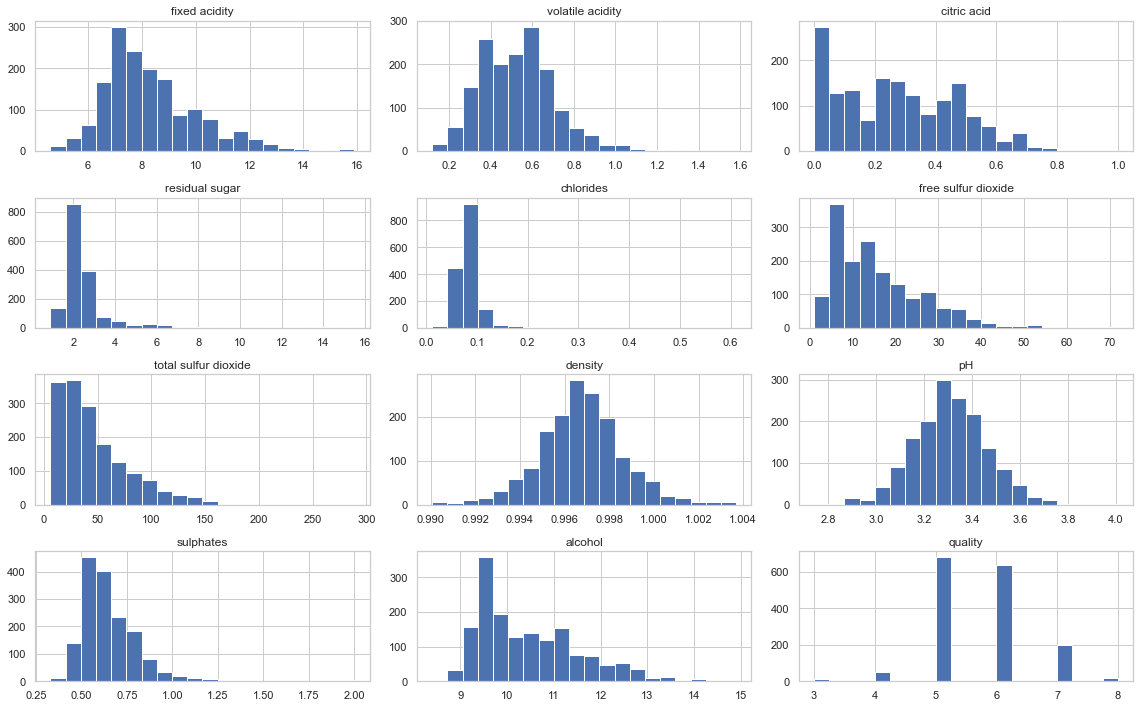

In [25]:
feats = get_quant_features(df)
draw_histograms(df, feats, 4, 3)

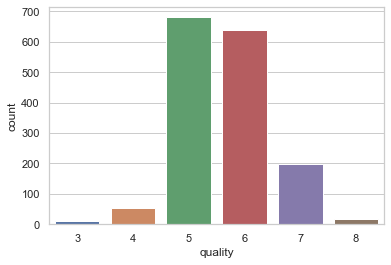

In [26]:
sns.countplot(x=df.quality);

In [27]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [28]:
df["good"] = 0
df.loc[df["quality"]>=5,"good"] = 1
df.loc[df["quality"]>=7,"good"] = 2

In [29]:
df.good.value_counts()

1    1319
2     217
0      63
Name: good, dtype: int64

In [30]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop(columns= ["quality","good"], axis=1).columns)

# for column in list_columns:
#     f, ax = plt.subplots(figsize=(5, 3))
#     sns.boxplot(x=df[column], palette="vlag")
#     ax.set_xlabel(column,fontsize=15)
#     ax.tick_params(labelsize=15);

### Podział na zbiór treningowy i testowy

In [31]:
# Podział na zbiór treningowy i testowy

X = df.drop(columns= ["quality","good"], axis=1)
y = df.good

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)
y_train.value_counts()

1    923
2    152
0     44
Name: good, dtype: int64

In [32]:
y_test.value_counts()

1    396
2     65
0     19
Name: good, dtype: int64

### Oversampling / Undersampling   - zakomentowane

In [33]:
# # instantiating over and under sampler
# over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
over = SMOTE()
# under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
# under = RandomUnderSampler(sampling_strategy=under_strategy)

# # now to comine over and under sampling
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

X_combined, y_combined = over.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_combined)}")

Oversampled: Counter({1: 923, 2: 923, 0: 923})


In [16]:
# y_combined.value_counts()

### Usuwanie outlier'ów

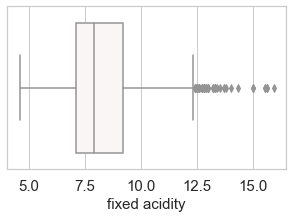

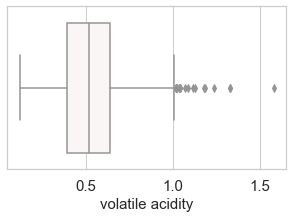

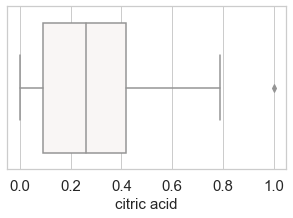

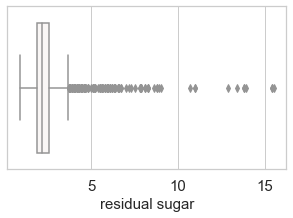

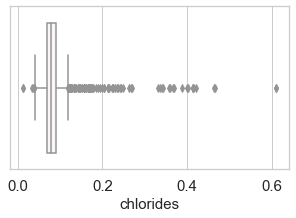

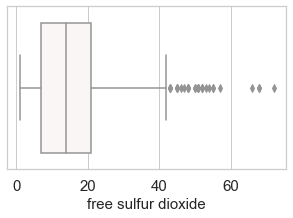

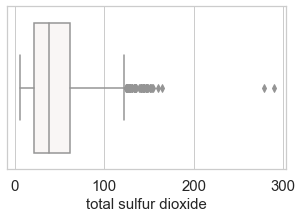

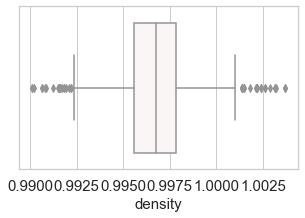

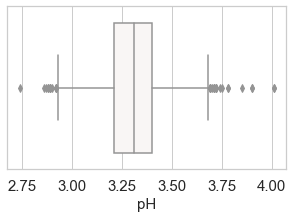

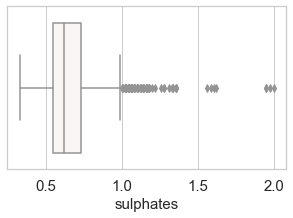

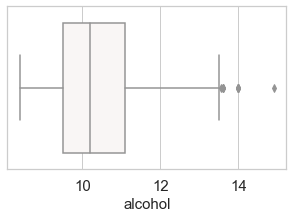

In [34]:
# # Boxploty przed usunięciem outlier'ów

sns.set_theme(style="whitegrid")

list_columns_comb = list(X.columns)

for column in list_columns_comb:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=X[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [35]:
def drop_outliers(dff, column):
    iqr = np.percentile(dff[column], 75) - np.percentile(dff[column], 25)
    dff.drop(dff[dff[column] < np.percentile(dff[column], 25) - 3.0 * iqr].index, inplace=True)
    dff.drop(dff[dff[column] > np.percentile(dff[column], 75) + 3.0 * iqr].index, inplace=True)
    return dff

In [36]:
df_train = pd.concat([X_combined, y_combined], axis=1)
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good
0,7.1,0.710,0.00,1.9,0.080,14.0,35.0,0.9972,3.47,0.55,9.4,1
1,7.2,0.650,0.02,2.3,0.094,5.0,31.0,0.9993,3.67,0.80,9.7,1
2,6.9,0.490,0.10,2.3,0.074,12.0,30.0,0.9959,3.42,0.58,10.2,1
3,10.7,0.350,0.53,2.6,0.070,5.0,16.0,0.9972,3.15,0.65,11.0,2
4,7.3,0.695,0.00,2.5,0.075,3.0,13.0,0.9980,3.49,0.52,9.2,1


In [37]:
df_train.shape

(2769, 12)

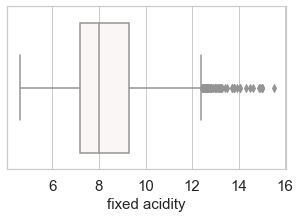

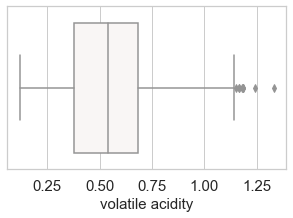

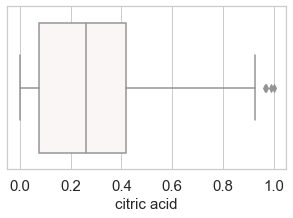

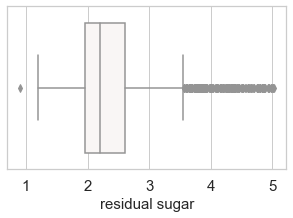

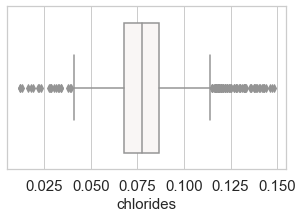

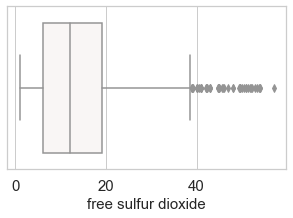

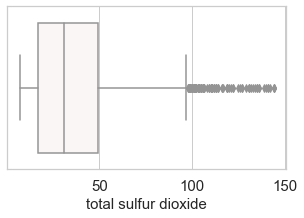

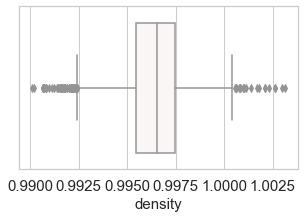

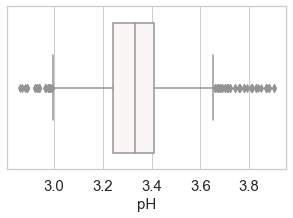

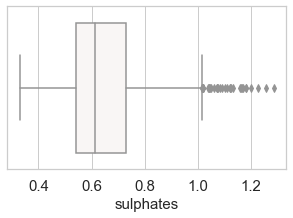

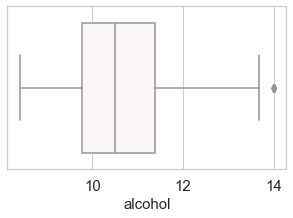

In [38]:
for column in list_columns:
    drop_outliers(df_train, column=column)
    
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df_train[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [39]:
X_train_outlier = df_train.drop('good',axis=1)
y_train_outlier = df_train.good

y_train_outlier.value_counts()

2    856
1    824
0    818
Name: good, dtype: int64

In [40]:

def drop_outliers_test(df_train, df_test, column):
    iqr = np.percentile(df_train[column], 75) - np.percentile(df_train[column], 25)
    df_test.drop(df_test[df_test[column] < np.percentile(df_train[column], 25) - 3.0 * iqr].index, inplace=True)
    df_test.drop(df_test[df_test[column] > np.percentile(df_train[column], 75) + 3.0 * iqr].index, inplace=True)
    return df_test

In [41]:
y_test.value_counts()

1    396
2     65
0     19
Name: good, dtype: int64

In [42]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good
435,12.3,0.39,0.63,2.30,0.091,6.0,18.0,1.00040,3.16,0.49,9.5,1
125,9.0,0.62,0.04,1.90,0.146,27.0,90.0,0.99840,3.16,0.70,9.4,1
1245,7.4,0.55,0.19,1.80,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,1
721,8.9,0.48,0.24,2.85,0.094,35.0,106.0,0.99820,3.10,0.53,9.2,1
289,11.6,0.42,0.53,3.30,0.105,33.0,98.0,1.00100,3.20,0.95,9.2,1


In [43]:
df_test.shape

(480, 12)

In [44]:
df_train_2 = pd.concat([X_combined, y_combined], axis=1)
df_train_2.shape

(2769, 12)

In [45]:
for column in list_columns:
    drop_outliers_test(df_train_2, df_test, column=column)

In [46]:
df_test.shape

(437, 12)

In [47]:
X_test_outlier = df_test.drop("good", axis=1)
y_test_outlier = df_test.good

y_test_outlier.value_counts()

1    363
2     57
0     17
Name: good, dtype: int64

### Normalizacja

In [48]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train_outlier)

X_train_std = scaler.transform(X_train_outlier)

print(scaler.mean_, scaler.scale_)

[ 8.32687435  0.5470269   0.25855813  2.41039484  0.07827937 14.13608068
 37.94262252  0.99649437  3.33358486  0.64105674 10.65127229] [1.66017662e+00 2.01718328e-01 1.91857804e-01 7.06956581e-01
 1.65521323e-02 9.52339155e+00 2.61214441e+01 1.72132875e-03
 1.42071857e-01 1.37485194e-01 1.06934185e+00]


In [49]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test_outlier)

## SVC

In [20]:
# SVC?

In [62]:
parameters_SVC = {
    "C": [0.1, 1, 10, 50],
    "gamma": [0.0001, 0.0005, 0.001, 0.005], 
    "kernel": ('linear','poly','rbf', 'sigmoid'),
    "degree": [2,4] 
    
}

model_SVC = SVC(probability=True)
model_SVC_with_best_params = GridSearchCV(model_SVC, parameters_SVC)
model_SVC_with_best_params.fit(X_train_std,y_train)
model_SVC_best_params = model_SVC_with_best_params.best_params_

ValueError: Found input variables with inconsistent numbers of samples: [2498, 1119]

In [22]:
model_SVC_best_params

{'C': 10, 'degree': 2, 'gamma': 0.005, 'kernel': 'rbf'}

In [23]:
predictions_SVC = model_SVC_with_best_params.predict(X_test_std)

              precision    recall  f1-score   support

           0      0.752     0.762     0.757       223
           1      0.791     0.782     0.787       257

    accuracy                          0.773       480
   macro avg      0.772     0.772     0.772       480
weighted avg      0.773     0.773     0.773       480

Overall Accuracy: 0.7729166666666667
Overall Precision: 0.7717754860288482
Overall Recall: 0.7722165029400987


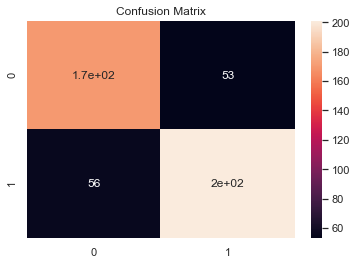

In [24]:
cm = confusion_matrix(y_test, predictions_SVC)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
    
acc = accuracy_score(y_test, predictions_SVC)
pre = precision_score(y_test, predictions_SVC, average="macro")
rec = recall_score(y_test, predictions_SVC, average="macro")
# Prediction Report
print(classification_report(y_test, predictions_SVC, digits=3))
print("Overall Accuracy:", acc)
print("Overall Precision:", pre)
print("Overall Recall:", rec)

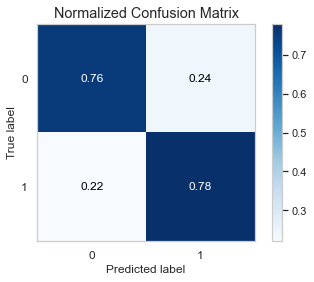

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred=predictions_SVC, normalize=True)
plt.show()

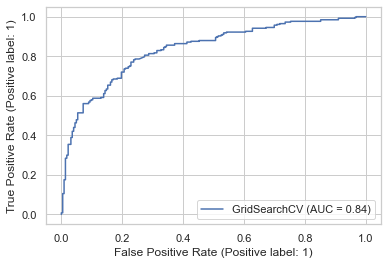

In [26]:
plot_roc_curve(model_SVC_with_best_params, X_test_std, y_test)
y_score = model_SVC_with_best_params.predict_proba(X_test_std)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

In [27]:
auc

0.835354469473574

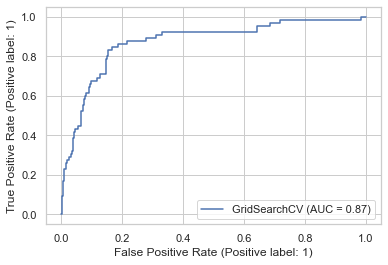

In [61]:
plot_roc_curve(model_SVC_with_best_params, X_test_std, y_test)
pass

In [50]:
model_RF = RandomForestClassifier(random_state=12)
model_RF.fit(X_train_std, y_train_outlier)

cross_val_score(model_RF, X_train_std, y_train_outlier, cv=5)

array([0.918     , 0.942     , 0.914     , 0.93787575, 0.94388778])

In [51]:
model_RF.score(X_test_std, y_test_outlier)

0.7894736842105263

In [52]:
y_pred_RF = model_RF.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF))

Confusion matrix - tablica pomyłek
 [[  4  13   0]
 [ 16 299  48]
 [  0  15  42]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           0       0.20      0.24      0.22        17
           1       0.91      0.82      0.87       363
           2       0.47      0.74      0.57        57

    accuracy                           0.79       437
   macro avg       0.53      0.60      0.55       437
weighted avg       0.83      0.79      0.80       437



In [53]:
param_grid_RF = {"n_estimators": [10, 17, 25, 33, 41, 48, 56, 64, 72, 80,100,200],
    "ccp_alpha" : [0, 0.2, 0.02],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], 
           "min_samples_split":[3,5,7,9,11,13,15,17,20],
           "bootstrap": [True,False]}

In [54]:
random_search_RF = RandomizedSearchCV(model_RF,
                                   param_distributions=param_grid_RF,
                                   cv=5,
                                   n_iter=500,
                                   verbose=1)
random_search_RF.fit(X_train_std, y_train_outlier)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12),
                   n_iter=500,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0, 0.2, 0.02],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [3, 5, 7, 9, 11,
                                                              13, 15, 17, 20],
                                        'min_weight_fraction_

In [55]:
print("Najlepsze parametry: ", random_search_RF.best_params_)
print("Najwyższy score: ", random_search_RF.best_score_)

Najlepsze parametry:  {'n_estimators': 100, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_leaf_nodes': 80, 'max_features': 'sqrt', 'max_depth': 7, 'ccp_alpha': 0, 'bootstrap': False}
Najwyższy score:  0.7281859719438877


In [56]:
param_grid_RF_2 = {"n_estimators": [200,100],
            "max_depth" : [7,20],
           "min_samples_leaf":[1,10],
           "min_weight_fraction_leaf":[0.0,0.1,0.2],
           "max_leaf_nodes":[None,80],
           'max_features': ['auto', 'sqrt'], 
           "min_samples_split":[3,20],
           "bootstrap": [True,False]}

In [57]:
grid_RF = GridSearchCV(model_RF, param_grid=param_grid_RF_2, cv=5, scoring="f1_micro", verbose=0, n_jobs=-1)
grid_RF.fit(X_train_std, y_train_outlier)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [7, 20],
                         'max_features': ['auto', 'sqrt'],
                         'max_leaf_nodes': [None, 80],
                         'min_samples_leaf': [1, 10],
                         'min_samples_split': [3, 20],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'n_estimators': [200, 100]},
             scoring='f1_micro')

In [58]:
print("Najlepsze parametry: ", grid_RF.best_params_)
print("Najwyższy score: ", grid_RF.best_score_)

Najlepsze parametry:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200}
Najwyższy score:  0.93835751503006


In [59]:
model_RF_opt = RandomForestClassifier(random_state=12, max_depth=20, max_features='auto', max_leaf_nodes= None, min_samples_leaf=1,min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=200 )
model_RF_opt.fit(X_train_std, y_train_outlier)

cross_val_score(model_RF_opt, X_train_std, y_train_outlier, cv=5)

array([0.906     , 0.942     , 0.91      , 0.93386774, 0.94589178])

In [60]:
model_RF_opt.score(X_test_std, y_test_outlier)

0.7963386727688787

In [61]:
y_pred_RF_opt = model_RF_opt.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_RF_opt))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_RF_opt))

Confusion matrix - tablica pomyłek
 [[  4  13   0]
 [ 16 299  48]
 [  0  12  45]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           0       0.20      0.24      0.22        17
           1       0.92      0.82      0.87       363
           2       0.48      0.79      0.60        57

    accuracy                           0.80       437
   macro avg       0.54      0.62      0.56       437
weighted avg       0.84      0.80      0.81       437

